In [1]:
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import numpy as np
import os


Load the MNIST Dataset.

In [2]:
(X_train_all, y_train_all), (X_test, y_test) = keras.datasets.mnist.load_data()

Check the shape of the datasets.

In [3]:
X_train_all.shape

(60000, 28, 28)

In [4]:
X_test.shape

(10000, 28, 28)

We Split the trainig dataset into the training and validation sets respectively, and also scale the pixel intensities to range 0 - 1 and also converts to float value.

In [5]:
X_train, X_valid = X_train_all[ : 50000] / 255.0, X_train_all[50000 : ] / 255.0

y_train, y_valid = y_train_all[ : 50000], y_train_all[50000 : ]

In [6]:
X_train.shape

(50000, 28, 28)

In [7]:
X_valid.shape

(10000, 28, 28)

In [8]:
y_train

array([5, 0, 4, ..., 8, 4, 8], dtype=uint8)

Display some of the images in the dataset.

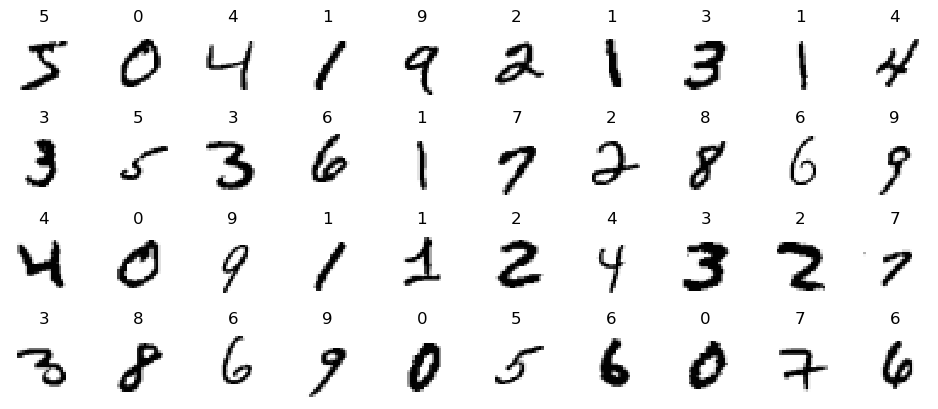

In [9]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

We'll use Learning rate scheduler to control how the learning rate of the optimizer changes over time.

In [10]:
k = keras.backend

class LearningRateFinder(keras.callbacks.Callback):
    def __init__(self, factor):
        super(LearningRateFinder, self).__init__()
        self.rates = []
        self.losses = []
        self.factor = factor

    def on_batch_end(self, batch, logs):
        rate = keras.backend.get_value(self.model.optimizer.learning_rate)
        self.rates.append(rate)
        self.losses.append(logs['loss'])
        k.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [11]:
keras.backend.clear_session()
np.random.seed(100)
tf.random.set_seed(100)

Build the Model Architecture

In [12]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(300, activation = "relu"),
    keras.layers.Dense(100, activation = "relu"),
    keras.layers.Dense(10, activation = "softmax")
])

2024-02-11 23:10:48.926126: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-02-11 23:10:48.926150: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-11 23:10:48.926157: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-11 23:10:48.926212: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-11 23:10:48.926397: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Define the model optimizer, initializing a small learning rate.

In [13]:
optimizer = keras.optimizers.SGD(learning_rate = 9.4e-4)

Let's start with a small learning rate.

In [14]:
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = optimizer,
              metrics = ["accuracy"])

In [15]:
expon_lr = LearningRateFinder(factor = 1.005)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
hidden1 = model.layers[1]

In [18]:
weights, biases = hidden1.get_weights()

In [19]:
weights

array([[-0.01384395, -0.00843894, -0.00859422, ...,  0.03622538,
         0.03885134, -0.07107313],
       [-0.03240044, -0.05997855, -0.04003031, ..., -0.00416311,
         0.07208008, -0.04507531],
       [ 0.03814972, -0.00706774,  0.02668389, ...,  0.04019777,
         0.05239622, -0.05923838],
       ...,
       [ 0.00709661, -0.05585354,  0.0427431 , ..., -0.03748092,
         0.0218762 ,  0.06771415],
       [ 0.03064001,  0.05361949, -0.01471296, ..., -0.04435579,
         0.05441192,  0.04431932],
       [ 0.04101188, -0.01667193, -0.02294952, ..., -0.0553525 ,
        -0.05459525, -0.0456227 ]], dtype=float32)

In [20]:
weights.shape

(784, 300)

In [21]:
history = model.fit(X_train, y_train,
                    epochs = 1, validation_data = (X_valid, y_valid),
                    callbacks = [expon_lr])

   1/1563 [..............................] - ETA: 9:13 - loss: 2.4361 - accuracy: 0.0625

2024-02-11 23:10:49.567479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-02-11 23:10:49.585846: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.


1563/1563 [==============================] - 13s 8ms/step - loss: nan - accuracy: 0.5335 - val_loss: nan - val_accuracy: 0.0991


Plot of the learning rate and losses per epoch.

Text(0, 0.5, 'Loss')

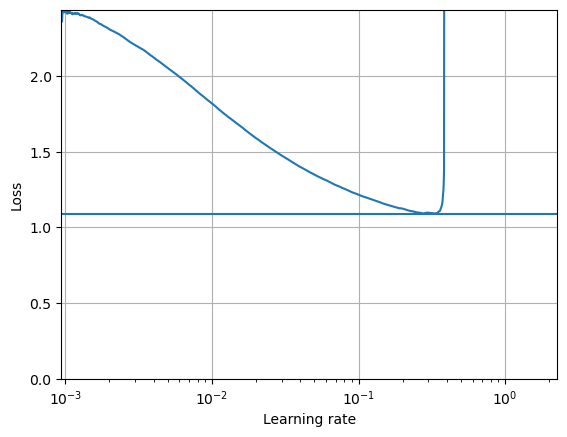

In [22]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

The loss starts shooting back up violently when the learning rate goes over 3.0e-1, so let's try using half of that, at 1.5e-1:

In [23]:
keras.backend.clear_session()
np.random.seed(100)
tf.random.set_seed(100)

In [24]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(300, activation = "relu"),
    keras.layers.Dense(100, activation = "relu"),
    keras.layers.Dense(10, activation = "softmax")
])

In [25]:
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(learning_rate = 3e-2),
              metrics = ["accuracy"])

In [26]:
run_index = 1
run_logdir = os.path.join(os.curdir, "my_logs", "run_{:03d}".format(run_index))
run_logdir

'./my_logs/run_001'

In [27]:
early_stopping = keras.callbacks.EarlyStopping(patience = 20)
checkpoint = keras.callbacks.ModelCheckpoint("learnr_model.h5", save_best_only = True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)



history = model.fit(X_train, y_train,
                    epochs = 50,
                    validation_data = (X_valid, y_valid),
                    callbacks = [checkpoint, early_stopping, tensorboard_cb])

Epoch 1/50
1563/1563 [==============================] - 11s 7ms/step - loss: 0.4577 - accuracy: 0.8685 - val_loss: 0.3114 - val_accuracy: 0.9107
Epoch 2/50
  27/1563 [..............................] - ETA: 9s - loss: 0.3218 - accuracy: 0.9086

/Users/fourier/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1563/1563 [==============================] - 10s 7ms/step - loss: 0.3297 - accuracy: 0.9063 - val_loss: 0.2953 - val_accuracy: 0.9174
Epoch 3/50
1563/1563 [==============================] - 10s 6ms/step - loss: 0.3903 - accuracy: 0.8936 - val_loss: 0.6784 - val_accuracy: 0.8551
Epoch 4/50
1563/1563 [==============================] - 10s 7ms/step - loss: 3.7101 - accuracy: 0.8029 - val_loss: 9.5591 - val_accuracy: 0.7838
Epoch 5/50
1563/1563 [==============================] - 10s 6ms/step - loss: nan - accuracy: 0.4025 - val_loss: nan - val_accuracy: 0.0991
Epoch 6/50
1563/1563 [==============================] - 10s 6ms/step - loss: nan - accuracy: 0.0986 - val_loss: nan - val_accuracy: 0.0991
Epoch 7/50
1563/1563 [==============================] - 10s 6ms/step - loss: nan - accuracy: 0.0986 - val_loss: nan - val_accuracy: 0.0991
Epoch 8/50
1563/1563 [==============================] - 10s 6ms/step - loss: nan - accuracy: 0.0986 - val_loss: nan - val_accuracy: 0.0991
Epoch 9/50
1563/1563

In [28]:
best_model = keras.models.load_model("learnr_model.h5")

best_model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 57.1374 - accuracy: 0.8993


[57.13743591308594, 0.8992999792098999]

In [29]:
%load_ext tensorboard

%tensorboard --logdir  ./my_logs